# Double Pendulum - Chaos Theory



In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [ ]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [ ]:
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [ ]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


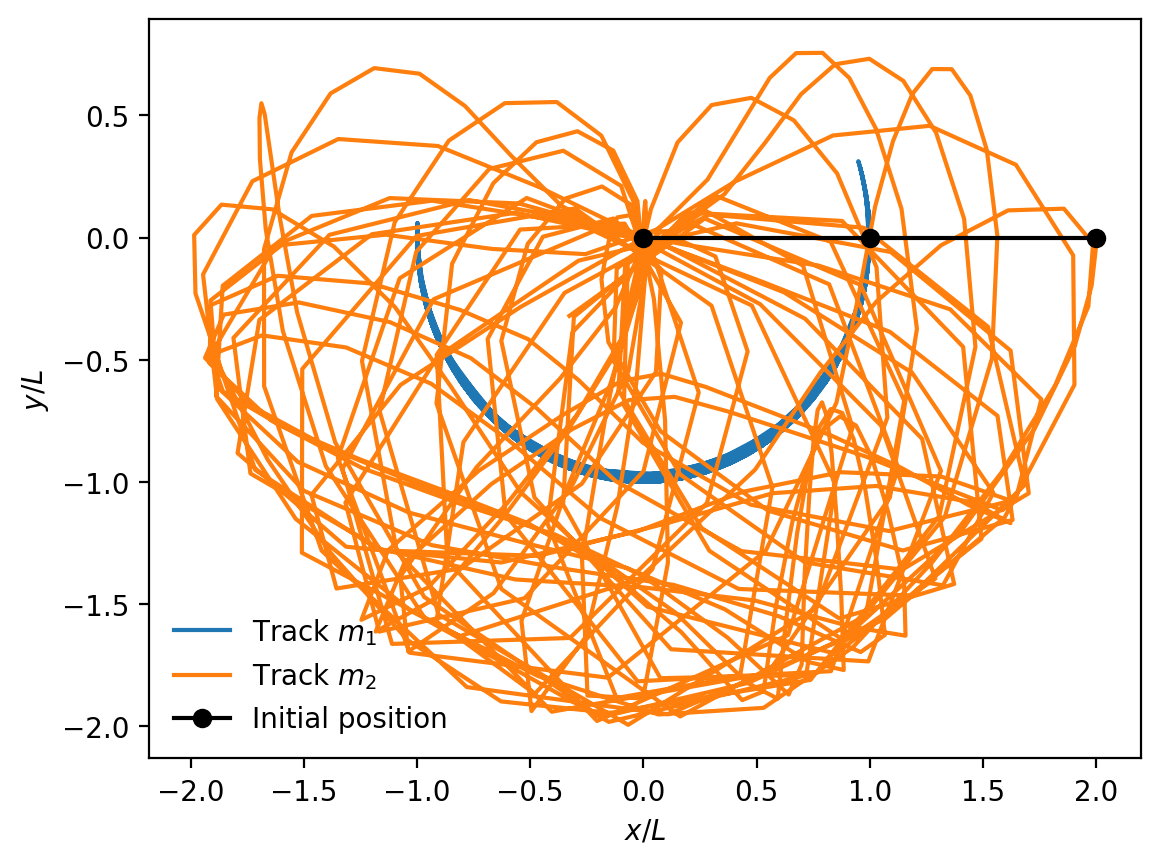

In [ ]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# Start


## 1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.

We train the data using LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.integrate import solve_ivp

# Define parameters
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81  # [m/s^2]. Gravitational acceleration

# Initial conditions
z0 = [np.pi / 4, 0, np.pi / 4, 0]
tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)

# ODE function and Cartesian conversion
def rhs(t, z, L1, L2, m1, m2, g):
    theta1, w1, theta2, w2 = z
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2 * m2 - m1 - m2
    w1dot = (L1 * m2 * cos12 * sin12 * w1**2 + L2 * m2 * sin12 * w2**2
            - m2 * g * cos12 * sin2 + (m1 + m2) * g * sin1) / (L1 * xi)
    w2dot = -(L2 * m2 * cos12 * sin12 * w2**2 + L1 * (m1 + m2) * sin12 * w1**2
            + (m1 + m2) * g * sin1 * cos12 - (m1 + m2) * g * sin2) / (L2 * xi)
    return w1, w1dot, w2, w2dot

def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    return x1, y1, x2, y2

# Solve the ODE
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z = ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# Prepare the data for training
def create_sequences(x1, y1, x2, y2, seq_length, future_steps):
    X, y = [], []
    for i in range(len(x1) - seq_length - future_steps):
        X.append(np.vstack([x1[i:i+seq_length], y1[i:i+seq_length], x2[i:i+seq_length], y2[i:i+seq_length]]).T)
        y.append(np.hstack([x1[i+seq_length+future_steps], y1[i+seq_length+future_steps], x2[i+seq_length+future_steps], y2[i+seq_length+future_steps]]))
    return np.array(X), np.array(y)

seq_length = 20
future_steps = 20
X, y = create_sequences(x1, y1, x2, y2, seq_length, future_steps)

# Normalize the data
input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
y_reshaped = y.reshape(-1, y.shape[-1])

X_normalized = input_scaler.fit_transform(X_reshaped)
y_normalized = output_scaler.fit_transform(y_reshaped)

# Reshape data back to the original dimensions
X_normalized = X_normalized.reshape(-1, seq_length, X.shape[2])
y_normalized = y_normalized.reshape(-1, y.shape[1])

# Train/test split
split_idx = int(len(X_normalized) * 0.8)
X_train, X_test = X_normalized[:split_idx], X_normalized[split_idx:]
y_train, y_test = y_normalized[:split_idx], y_normalized[split_idx:]

# Define and compile the LSTM model
def create_lstm_model(sequence_length, num_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))  # Predicting (x1_future, y1_future, x2_future, y2_future)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

lstm_model = create_lstm_model(seq_length, X_train.shape[2])

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict with the model
lstm_predictions_normalized = lstm_model.predict(X_test)

# Rescale predictions and true values
lstm_predictions_rescaled = output_scaler.inverse_transform(lstm_predictions_normalized)
y_test_rescaled = output_scaler.inverse_transform(y_test)






Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.9641 - val_loss: 0.8407
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7560 - val_loss: 0.5152
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5410 - val_loss: 0.3856
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4291 - val_loss: 0.2935
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3296 - val_loss: 0.2254
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2943 - val_loss: 0.1752
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2305 - val_loss: 0.1483
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.2192 - val_loss: 0.1145
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1790 - val_loss: 0.0800
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1799 - val_loss: 0.0619
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1614 - val_loss: 0.0548
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1576 - val_

## 2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

We now plot x1,y1 vs time and x2, y2 vs time from our trained data

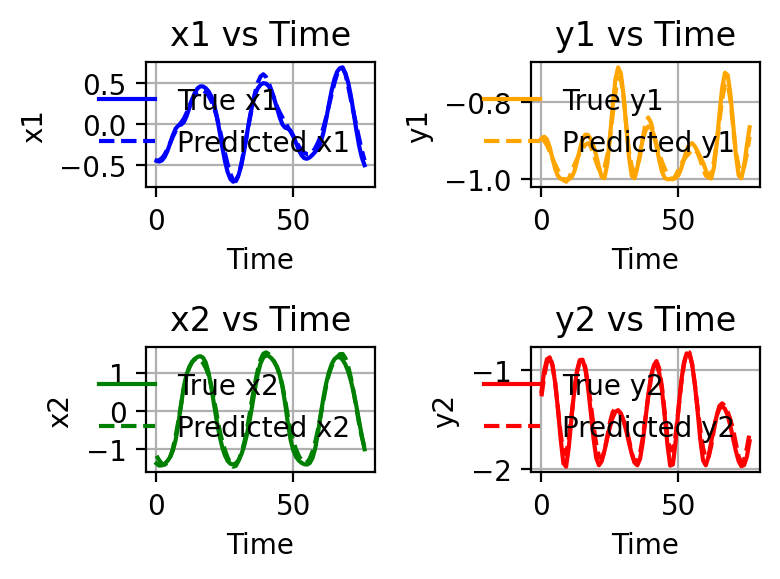

In [ ]:
# Plot predictions vs true values
def plot_time_series_prediction(true_values, predicted_values, time_steps):
    x1_true, y1_true, x2_true, y2_true = true_values
    x1_pred, y1_pred, x2_pred, y2_pred = predicted_values

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot x1 vs time
    axs[0, 0].plot(time_steps, x1_true[:len(time_steps)], label="True x1", color="blue")
    axs[0, 0].plot(time_steps, x1_pred, label="Predicted x1", linestyle="--", color="blue")
    axs[0, 0].set_title("x1 vs Time")
    axs[0, 0].set_xlabel("Time")
    axs[0, 0].set_ylabel("x1")
    axs[0, 0].legend(loc="upper right")
    axs[0, 0].grid(True)

    # Plot y1 vs time
    axs[0, 1].plot(time_steps, y1_true[:len(time_steps)], label="True y1", color="orange")
    axs[0, 1].plot(time_steps, y1_pred, label="Predicted y1", linestyle="--", color="orange")
    axs[0, 1].set_title("y1 vs Time")
    axs[0, 1].set_xlabel("Time")
    axs[0, 1].set_ylabel("y1")
    axs[0, 1].legend(loc="upper right")
    axs[0, 1].grid(True)

    # Plot x2 vs time
    axs[1, 0].plot(time_steps, x2_true[:len(time_steps)], label="True x2", color="green")
    axs[1, 0].plot(time_steps, x2_pred, label="Predicted x2", linestyle="--", color="green")
    axs[1, 0].set_title("x2 vs Time")
    axs[1, 0].set_xlabel("Time")
    axs[1, 0].set_ylabel("x2")
    axs[1, 0].legend(loc="upper right")
    axs[1, 0].grid(True)

    # Plot y2 vs time
    axs[1, 1].plot(time_steps, y2_true[:len(time_steps)], label="True y2", color="red")
    axs[1, 1].plot(time_steps, y2_pred, label="Predicted y2", linestyle="--", color="red")
    axs[1, 1].set_title("y2 vs Time")
    axs[1, 1].set_xlabel("Time")
    axs[1, 1].set_ylabel("y2")
    axs[1, 1].legend(loc="upper right")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Define the time steps for the test data
time_steps = np.arange(len(y_test_rescaled))  # Define the time steps based on the length of the test data
plot_time_series_prediction(
    (y_test_rescaled[:, 0], y_test_rescaled[:, 1], y_test_rescaled[:, 2], y_test_rescaled[:, 3]),
    (lstm_predictions_rescaled[:, 0], lstm_predictions_rescaled[:, 1], lstm_predictions_rescaled[:, 2], lstm_predictions_rescaled[:, 3]),
    time_steps
)

## 3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

We now plot deviation of position vs extrapolated time

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


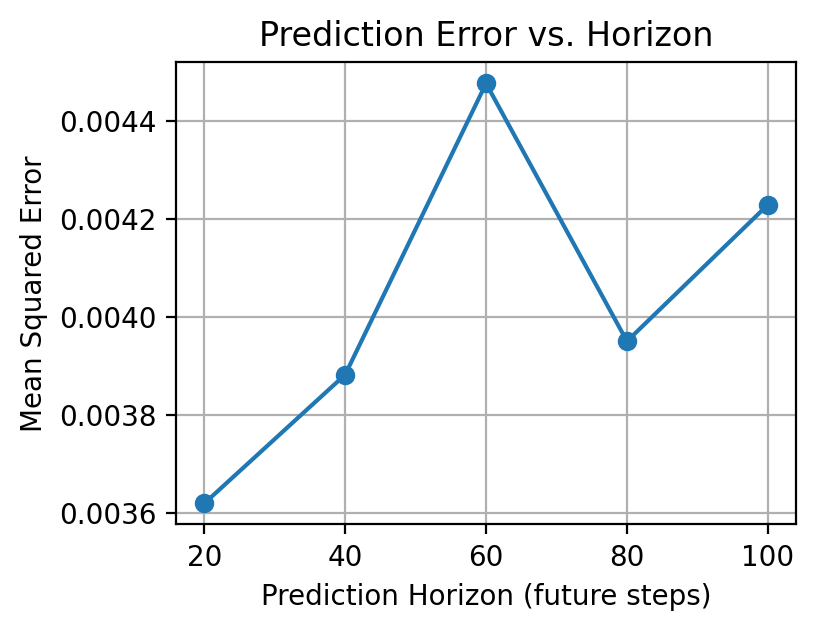

In [ ]:
# Initial conditions
z0 = [np.pi / 4, 0, np.pi / 4, 0]

def create_lstm_model(sequence_length, num_features, output_dim):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim))  # Predicting (x1_future, y1_future, x2_future, y2_future)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

# Prediction horizons to evaluate
horizons = range(20, 101, 20)  # From 20 to 100 with step of 20
errors = []

for future_steps in horizons:
    # Create sequences for the current prediction horizon
    X, y = create_sequences(x1, y1, x2, y2, seq_length, future_steps)

    # Normalize the data
    input_scaler = StandardScaler()
    output_scaler = StandardScaler()
    X_reshaped = X.reshape(-1, X.shape[-1])
    y_reshaped = y.reshape(-1, y.shape[-1])

    X_normalized = input_scaler.fit_transform(X_reshaped)
    y_normalized = output_scaler.fit_transform(y_reshaped)

    # Reshape data back to the original dimensions
    X_normalized = X_normalized.reshape(-1, seq_length, X.shape[2])
    y_normalized = y_normalized.reshape(-1, y.shape[1])

    # Train/test split
    split_idx = int(len(X_normalized) * 0.8)
    X_train, X_test = X_normalized[:split_idx], X_normalized[split_idx:]
    y_train, y_test = y_normalized[:split_idx], y_normalized[split_idx:]

    # Create and train the LSTM model
    lstm_model = create_lstm_model(seq_length, X_train.shape[2], y_train.shape[1])
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predict with the model
    lstm_predictions_normalized = lstm_model.predict(X_test)

    # Rescale predictions and true values
    lstm_predictions_rescaled = output_scaler.inverse_transform(lstm_predictions_normalized)
    y_test_rescaled = output_scaler.inverse_transform(y_test)

    # Calculate the mean squared error for the current horizon
    errors.append(np.mean((lstm_predictions_rescaled - y_test_rescaled) ** 2))

# Plot the results
plt.figure(figsize=(14, 10))
plt.plot(horizons, errors, marker='o')
plt.xlabel('Extrapolated time (future steps)')
plt.ylabel('Mean Squared Error')
plt.title('Prediction Error vs. Extrapolated time')
plt.grid(True)
plt.show()


## 4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.

We now repeat all steps for new z0

In [ ]:
# Initial conditions
z0 = [np.pi / 2, 0, np.pi / 2, 0]

seq_length = 20
future_steps = 20
X, y = create_sequences(x1, y1, x2, y2, seq_length, future_steps)

# Normalize the data
input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
y_reshaped = y.reshape(-1, y.shape[-1])

X_normalized = input_scaler.fit_transform(X_reshaped)
y_normalized = output_scaler.fit_transform(y_reshaped)

# Reshape data back to the original dimensions
X_normalized = X_normalized.reshape(-1, seq_length, X.shape[2])
y_normalized = y_normalized.reshape(-1, y.shape[1])

# Train/test split
split_idx = int(len(X_normalized) * 0.8)
X_train, X_test = X_normalized[:split_idx], X_normalized[split_idx:]
y_train, y_test = y_normalized[:split_idx], y_normalized[split_idx:]

# Define and compile the LSTM model
def create_lstm_model(sequence_length, num_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))  # Predicting (x1_future, y1_future, x2_future, y2_future)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

lstm_model = create_lstm_model(seq_length, X_train.shape[2])

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict with the model
lstm_predictions_normalized = lstm_model.predict(X_test)

# Rescale predictions and true values
lstm_predictions_rescaled = output_scaler.inverse_transform(lstm_predictions_normalized)
y_test_rescaled = output_scaler.inverse_transform(y_test)

# Plot predictions vs true values
def plot_time_series_prediction(true_values, predicted_values, time_steps):
    x1_true, y1_true, x2_true, y2_true = true_values
    x1_pred, y1_pred, x2_pred, y2_pred = predicted_values

    fig, axs = plt.subplots(2, 2, figsize=(4, 3))

    # Plot x1 vs time
    axs[0, 0].plot(time_steps, x1_true[:len(time_steps)], label="True x1", color="blue")
    axs[0, 0].plot(time_steps, x1_pred, label="Predicted x1", linestyle="--", color="blue")
    axs[0, 0].set_title("x1 vs Time")
    axs[0, 0].set_xlabel("Time")
    axs[0, 0].set_ylabel("x1")
    axs[0, 0].legend(loc="upper right")
    axs[0, 0].grid(True)

    # Plot y1 vs time
    axs[0, 1].plot(time_steps, y1_true[:len(time_steps)], label="True y1", color="orange")
    axs[0, 1].plot(time_steps, y1_pred, label="Predicted y1", linestyle="--", color="orange")
    axs[0, 1].set_title("y1 vs Time")
    axs[0, 1].set_xlabel("Time")
    axs[0, 1].set_ylabel("y1")
    axs[0, 1].legend(loc="upper right")
    axs[0, 1].grid(True)

    # Plot x2 vs time
    axs[1, 0].plot(time_steps, x2_true[:len(time_steps)], label="True x2", color="green")
    axs[1, 0].plot(time_steps, x2_pred, label="Predicted x2", linestyle="--", color="green")
    axs[1, 0].set_title("x2 vs Time")
    axs[1, 0].set_xlabel("Time")
    axs[1, 0].set_ylabel("x2")
    axs[1, 0].legend(loc="upper right")
    axs[1, 0].grid(True)

    # Plot y2 vs time
    axs[1, 1].plot(time_steps, y2_true[:len(time_steps)], label="True y2", color="red")
    axs[1, 1].plot(time_steps, y2_pred, label="Predicted y2", linestyle="--", color="red")
    axs[1, 1].set_title("y2 vs Time")
    axs[1, 1].set_xlabel("Time")
    axs[1, 1].set_ylabel("y2")
    axs[1, 1].legend(loc="upper right")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Define the time steps for the test data
time_steps = np.arange(len(y_test_rescaled))  # Define the time steps based on the length of the test data
plot_time_series_prediction(
    (y_test_rescaled[:, 0], y_test_rescaled[:, 1], y_test_rescaled[:, 2], y_test_rescaled[:, 3]),
    (lstm_predictions_rescaled[:, 0], lstm_predictions_rescaled[:, 1], lstm_predictions_rescaled[:, 2], lstm_predictions_rescaled[:, 3]),
    time_steps
)




In [ ]:
# New initial conditions
z0 = [np.pi / 2, 0, np.pi / 2, 0]


# Plot the results
plt.figure(figsize=(14, 10))
plt.plot(horizons, errors, marker='o')
plt.xlabel('Extrapolated time (future steps)')
plt.ylabel('Mean Squared Error')
plt.title('Prediction Error vs. Extrapolated time with Initial Conditions [π/2, 0, π/2, 0]')
plt.grid(True)
plt.show()


## 5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

We now repeat all steps for from 1-4

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 1.0193 - val_loss: 0.7630
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9966 - val_loss: 0.7585
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0403 - val_loss: 0.7559
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0335 - val_loss: 0.7470
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9260 - val_loss: 0.7561
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9223 - val_loss: 0.7659
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8758 - val_loss: 0.7593
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8337 - val_loss: 0.7844
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7850 - val_loss: 0.7733
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8240 - val_loss: 0.7956
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7472 - val_loss: 0.8123
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7895 - val_l

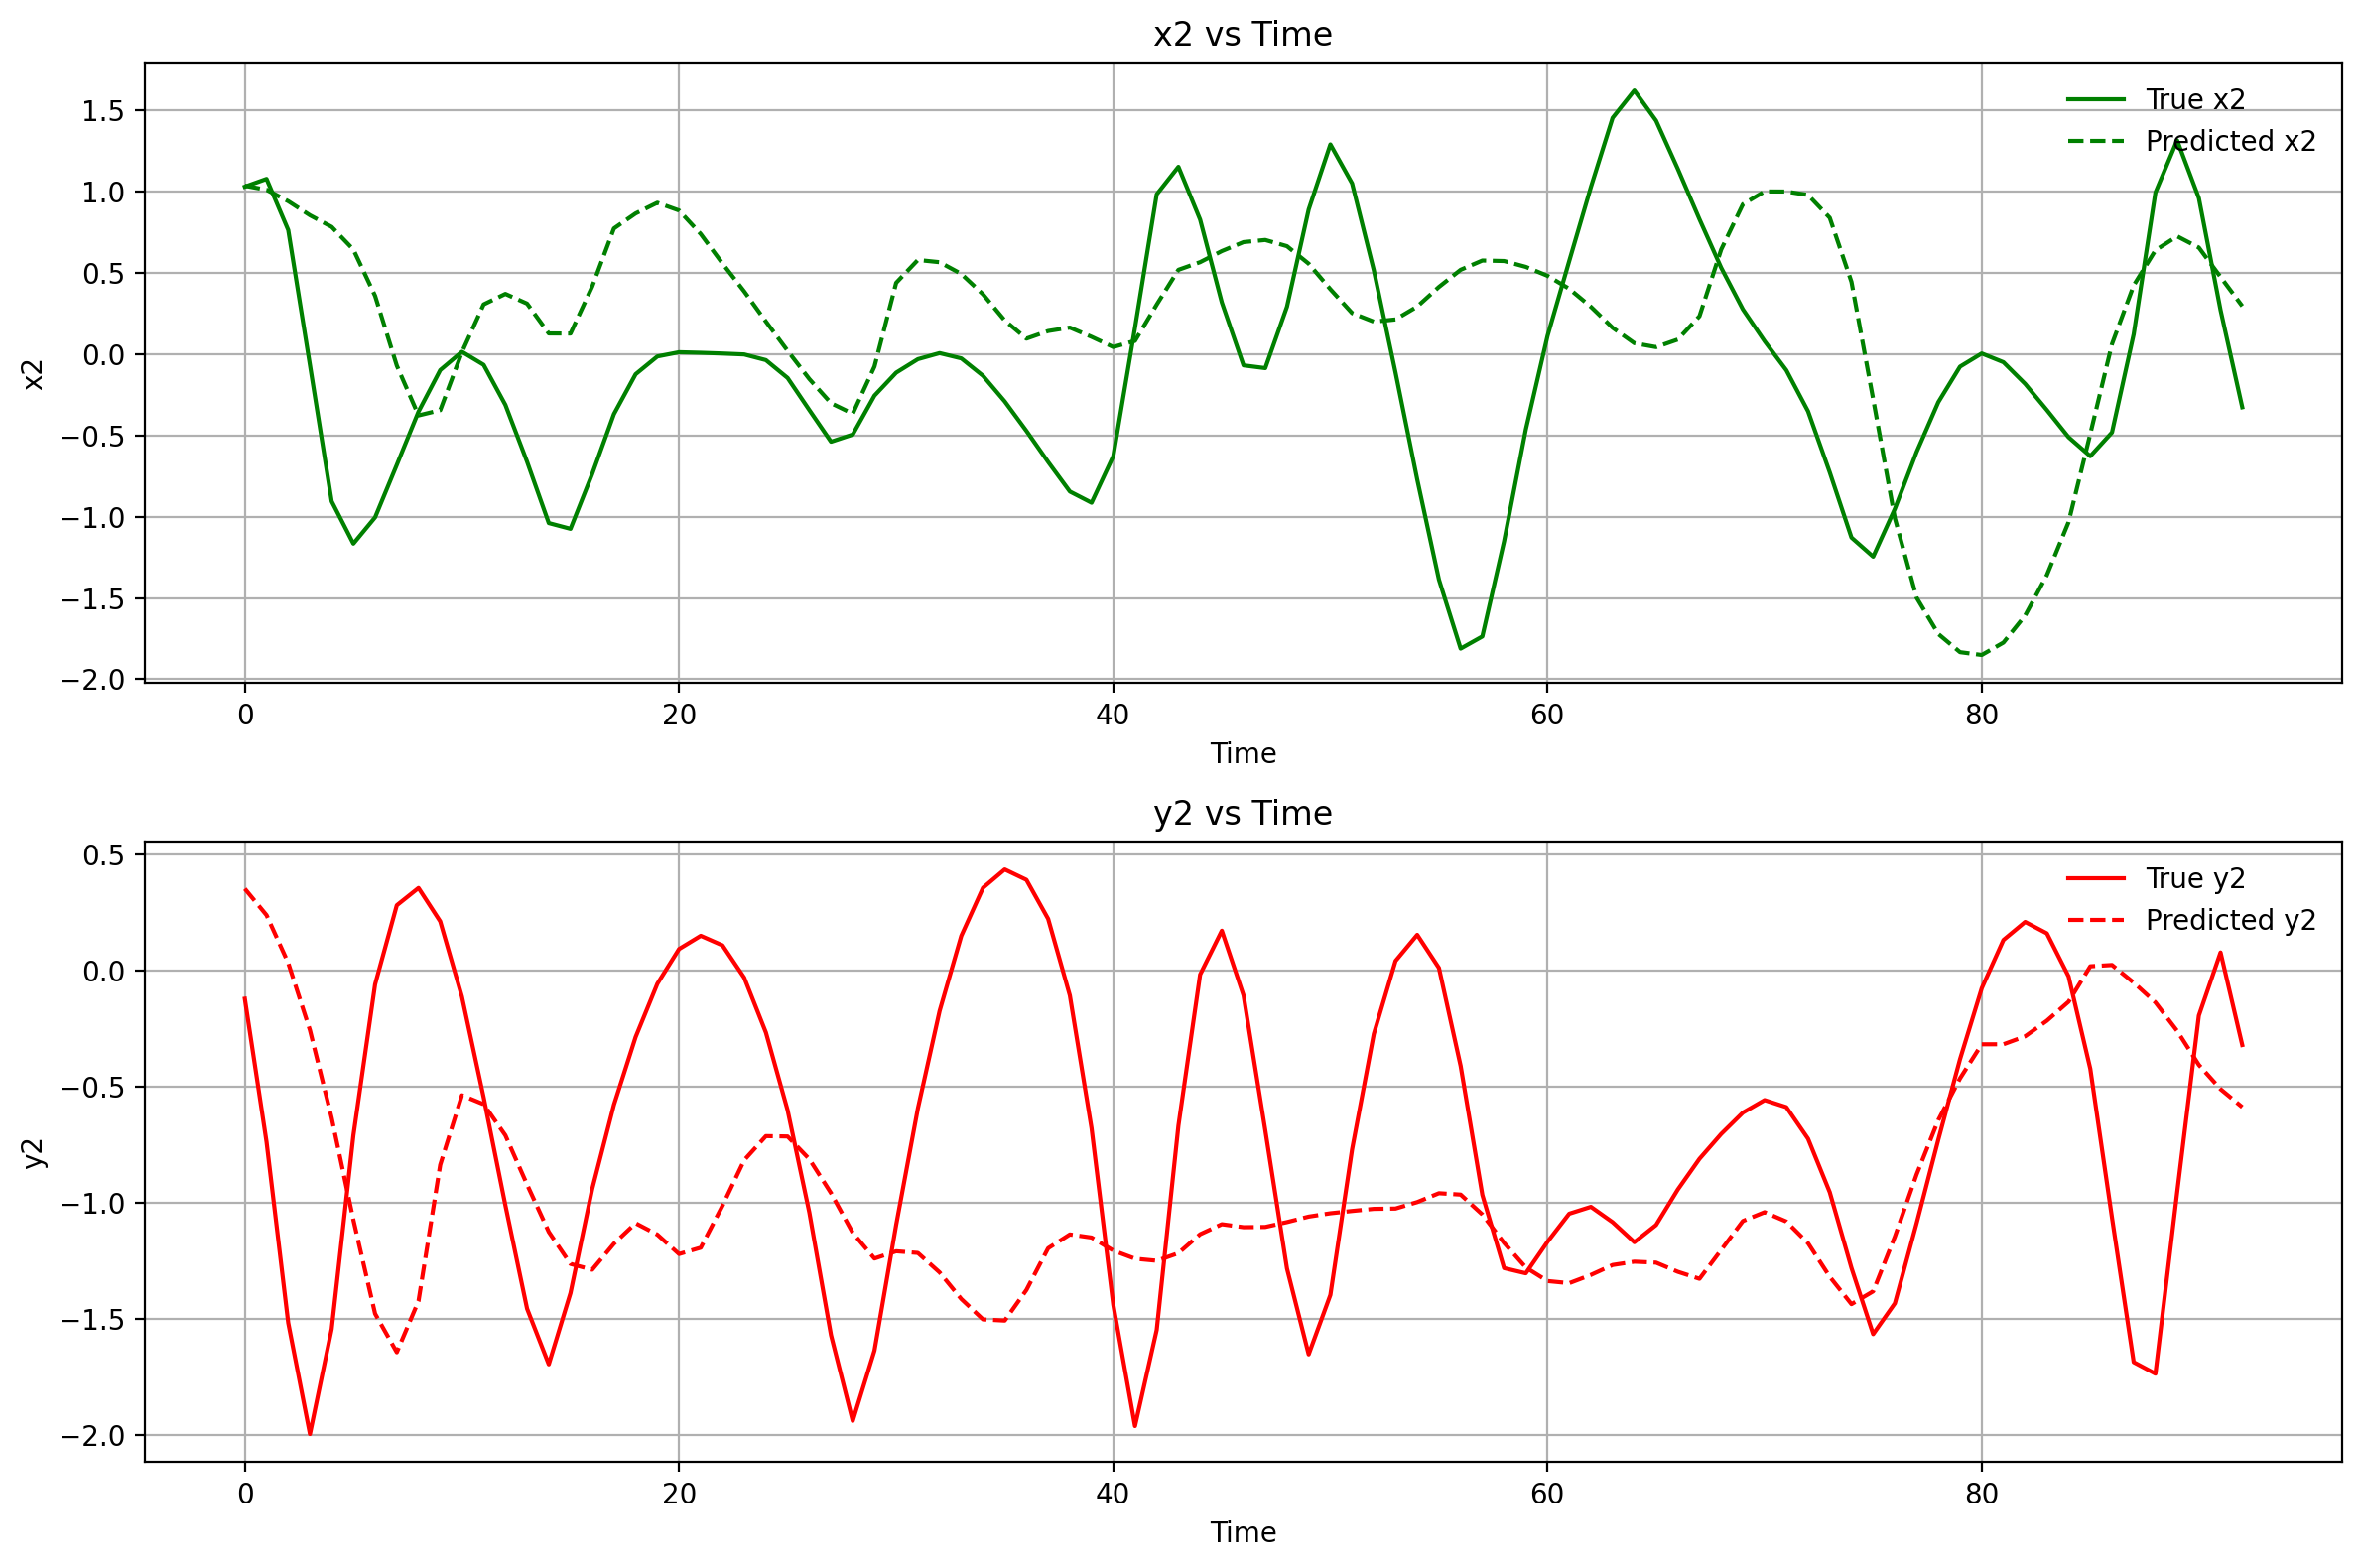

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define parameters
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81  # [m/s^2]. Gravitational acceleration

# Initial conditions
z0 = [np.pi / 2, 0, np.pi / 2, 0]
tmax, dt = 50, 0.1
t = np.arange(0, tmax + dt, dt)

# ODE function and Cartesian conversion
def rhs(t, z, L1, L2, m1, m2, g):
    theta1, w1, theta2, w2 = z
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2 * m2 - m1 - m2
    w1dot = (L1 * m2 * cos12 * sin12 * w1**2 + L2 * m2 * sin12 * w2**2
            - m2 * g * cos12 * sin2 + (m1 + m2) * g * sin1) / (L1 * xi)
    w2dot = -(L2 * m2 * cos12 * sin12 * w2**2 + L1 * (m1 + m2) * sin12 * w1**2
            + (m1 + m2) * g * sin1 * cos12 - (m1 + m2) * g * sin2) / (L2 * xi)
    return w1, w1dot, w2, w2dot

def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    return x1, y1, x2, y2

# Solve the ODE
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z = ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# Prepare data for m2
def create_sequences_m2(x2, y2, seq_length, future_steps):
    X, y = [], []
    for i in range(len(x2) - seq_length - future_steps):
        X.append(np.vstack([x2[i:i+seq_length], y2[i:i+seq_length]]).T)
        y.append(np.hstack([x2[i+seq_length+future_steps], y2[i+seq_length+future_steps]]))
    return np.array(X), np.array(y)

seq_length = 20
future_steps = 20
X_m2, y_m2 = create_sequences_m2(x2, y2, seq_length, future_steps)

# Normalize data
input_scaler_m2 = StandardScaler()
output_scaler_m2 = StandardScaler()
X_m2_reshaped = X_m2.reshape(-1, X_m2.shape[-1])
y_m2_reshaped = y_m2.reshape(-1, y_m2.shape[-1])

X_m2_normalized = input_scaler_m2.fit_transform(X_m2_reshaped)
y_m2_normalized = output_scaler_m2.fit_transform(y_m2_reshaped)

X_m2_normalized = X_m2_normalized.reshape(-1, seq_length, X_m2.shape[2])
y_m2_normalized = y_m2_normalized.reshape(-1, y_m2.shape[1])

# Train/test split
split_idx_m2 = int(len(X_m2_normalized) * 0.8)
X_train_m2, X_test_m2 = X_m2_normalized[:split_idx_m2], X_m2_normalized[split_idx_m2:]
y_train_m2, y_test_m2 = y_m2_normalized[:split_idx_m2], y_m2_normalized[split_idx_m2:]

def create_lstm_model(sequence_length, num_features, output_dim):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim))  # Predicting (x2_future, y2_future)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

# Define the output dimension for m2 (predicting x2 and y2)
output_dim_m2 = y_train_m2.shape[1]

# Define and compile the LSTM model for m2 only
lstm_model_m2 = create_lstm_model(seq_length, X_train_m2.shape[2], output_dim_m2)

# Train the model
history_m2 = lstm_model_m2.fit(X_train_m2, y_train_m2, epochs=50, batch_size=32, validation_data=(X_test_m2, y_test_m2))

# Evaluate the model
loss_m2 = lstm_model_m2.evaluate(X_test_m2, y_test_m2)
print(f"Test Loss (m2 only): {loss_m2}")

# Predict with the model
lstm_predictions_normalized_m2 = lstm_model_m2.predict(X_test_m2)

# Rescale predictions and true values
lstm_predictions_rescaled_m2 = output_scaler_m2.inverse_transform(lstm_predictions_normalized_m2)
y_test_rescaled_m2 = output_scaler_m2.inverse_transform(y_test_m2)

# Plot predictions vs true values for m2
def plot_time_series_prediction_m2(true_values, predicted_values, time_steps):
    x2_true, y2_true = true_values
    x2_pred, y2_pred = predicted_values

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot x2 vs time
    axs[0].plot(time_steps, x2_true[:len(time_steps)], label="True x2", color="green")
    axs[0].plot(time_steps, x2_pred, label="Predicted x2", linestyle="--", color="green")
    axs[0].set_title("x2 vs Time")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("x2")
    axs[0].legend(loc="upper right")
    axs[0].grid(True)

    # Plot y2 vs time
    axs[1].plot(time_steps, y2_true[:len(time_steps)], label="True y2", color="red")
    axs[1].plot(time_steps, y2_pred, label="Predicted y2", linestyle="--", color="red")
    axs[1].set_title("y2 vs Time")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("y2")
    axs[1].legend(loc="upper right")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Define the time steps for the test data
time_steps_m2 = np.arange(len(y_test_rescaled_m2))  # Define the time steps based on the length of the test data
plot_time_series_prediction_m2(
    (y_test_rescaled_m2[:, 0], y_test_rescaled_m2[:, 1]),
    (lstm_predictions_rescaled_m2[:, 0], lstm_predictions_rescaled_m2[:, 1]),
    time_steps_m2
)

step 3-

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


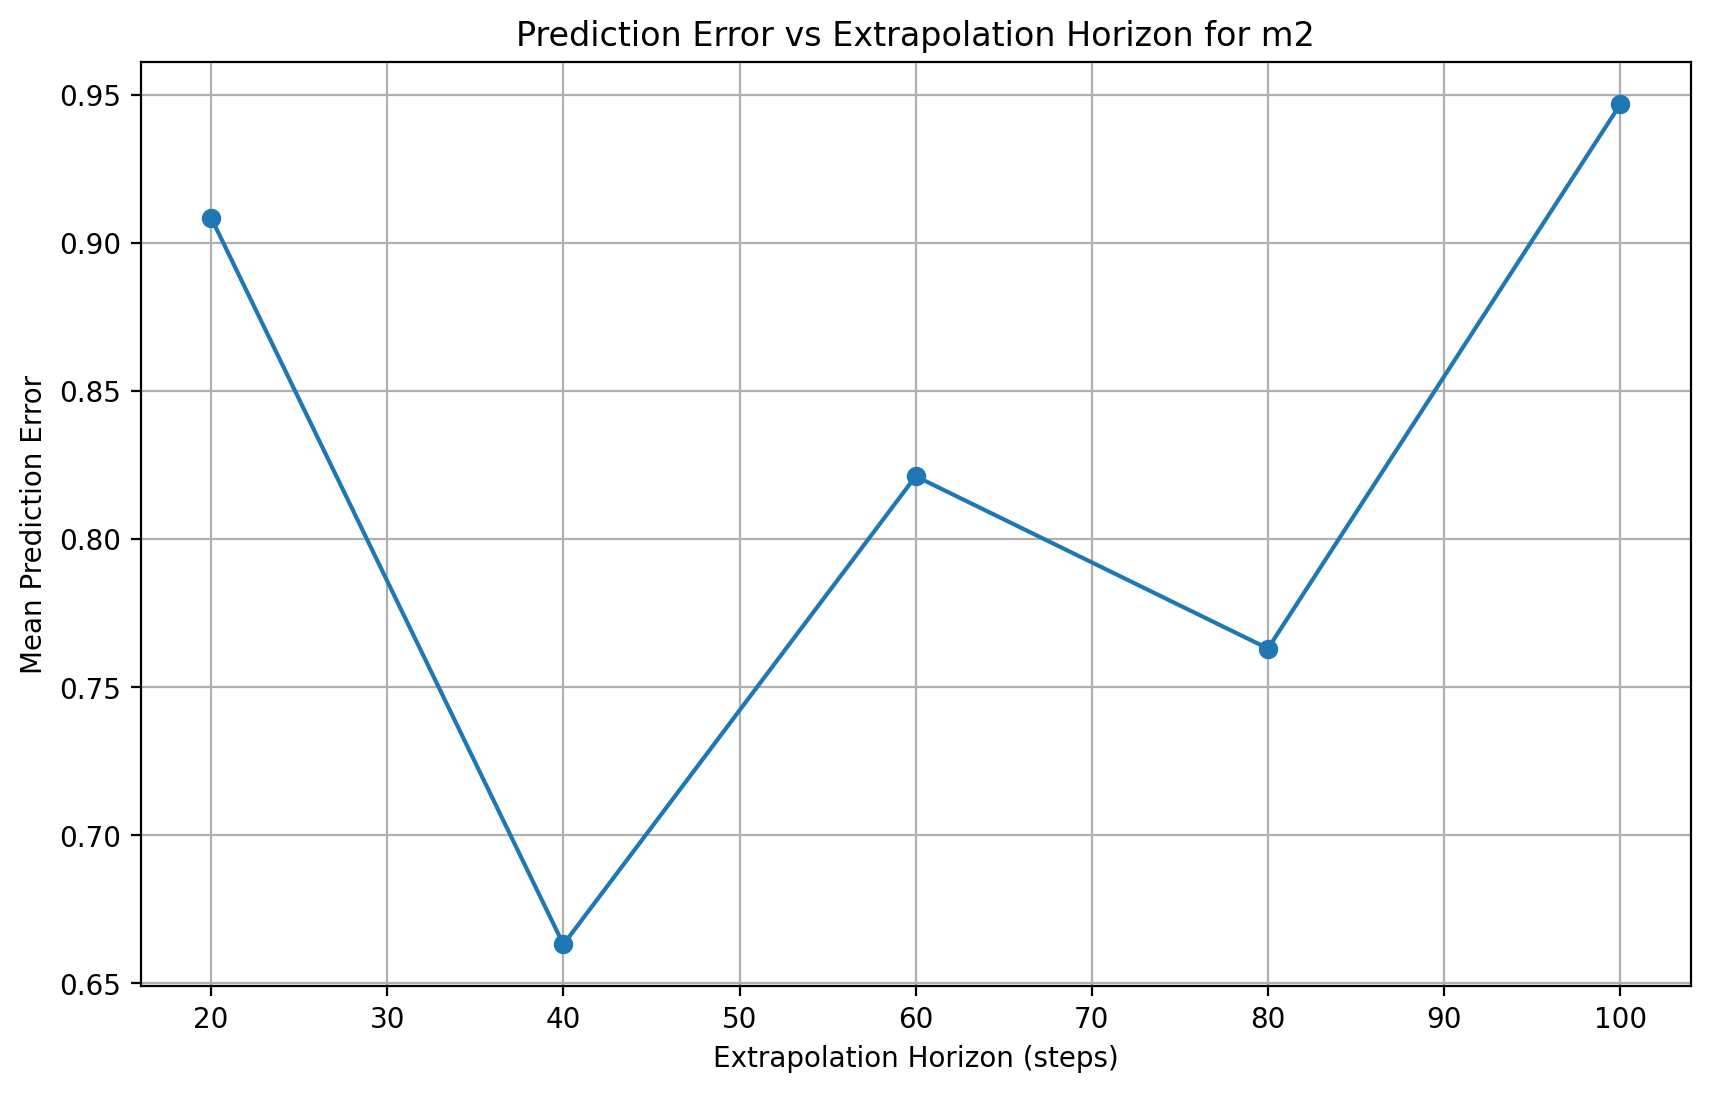

In [ ]:
def train_and_evaluate_model_m2(seq_length, future_steps, X_train, y_train, X_test, y_test):
    # Define the output dimension
    output_dim_m2 = y_train.shape[1]

    # Create and train the model
    model = create_lstm_model(seq_length, X_train.shape[2], output_dim_m2)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predict with the model
    predictions_normalized = model.predict(X_test)

    # Rescale predictions and true values
    predictions_rescaled = output_scaler_m2.inverse_transform(predictions_normalized)
    y_test_rescaled = output_scaler_m2.inverse_transform(y_test)

    # Calculate the prediction error
    errors = np.sqrt(np.mean((predictions_rescaled - y_test_rescaled) ** 2, axis=1))
    return errors

# Define the forecast horizons
horizons = range(20, 101, 20)  # Extrapolation times from 20*dt to 100*dt

errors = []
for horizon in horizons:
    X_m2, y_m2 = create_sequences_m2(x2, y2, seq_length, horizon)

    # Normalize the data
    X_m2_reshaped = X_m2.reshape(-1, X_m2.shape[-1])
    y_m2_reshaped = y_m2.reshape(-1, y_m2.shape[-1])

    X_m2_normalized = input_scaler_m2.fit_transform(X_m2_reshaped)
    y_m2_normalized = output_scaler_m2.fit_transform(y_m2_reshaped)

    X_m2_normalized = X_m2_normalized.reshape(-1, seq_length, X_m2.shape[2])
    y_m2_normalized = y_m2_normalized.reshape(-1, y_m2.shape[1])

    # Train and evaluate the model for each horizon
    split_idx_m2 = int(len(X_m2_normalized) * 0.8)
    X_train_m2, X_test_m2 = X_m2_normalized[:split_idx_m2], X_m2_normalized[split_idx_m2:]
    y_train_m2, y_test_m2 = y_m2_normalized[:split_idx_m2], y_m2_normalized[split_idx_m2:]

    errors.append(np.mean(train_and_evaluate_model_m2(seq_length, horizon, X_train_m2, y_train_m2, X_test_m2, y_test_m2)))

# Plot error vs horizon
plt.figure(figsize=(10, 6))
plt.plot(horizons, errors, marker='o')
plt.xlabel('Extrapolation time (steps)')
plt.ylabel('Mean Prediction Error')
plt.title('Prediction Error vs Extrapolation time for m2')
plt.grid(True)
plt.show()


Step 4-

In [ ]:
z0 = [np.pi / 2, 0, np.pi / 2, 0]

# Solve the ODE
ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z = ret.y
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

# Prepare data for m2 only
def create_sequences_m2(x2, y2, seq_length, future_steps):
    X, y = [], []
    for i in range(len(x2) - seq_length - future_steps):
        X.append(np.vstack([x2[i:i+seq_length], y2[i:i+seq_length]]).T)
        y.append(np.hstack([x2[i+seq_length+future_steps], y2[i+seq_length+future_steps]]))
    return np.array(X), np.array(y)

seq_length = 20
future_steps = 20
X_m2, y_m2 = create_sequences_m2(x2, y2, seq_length, future_steps)

# Normalize data
input_scaler_m2 = StandardScaler()
output_scaler_m2 = StandardScaler()
X_m2_reshaped = X_m2.reshape(-1, X_m2.shape[-1])
y_m2_reshaped = y_m2.reshape(-1, y_m2.shape[-1])

X_m2_normalized = input_scaler_m2.fit_transform(X_m2_reshaped)
y_m2_normalized = output_scaler_m2.fit_transform(y_m2_reshaped)

X_m2_normalized = X_m2_normalized.reshape(-1, seq_length, X_m2.shape[2])
y_m2_normalized = y_m2_normalized.reshape(-1, y_m2.shape[1])

# Train/test split
split_idx_m2 = int(len(X_m2_normalized) * 0.8)
X_train_m2, X_test_m2 = X_m2_normalized[:split_idx_m2], X_m2_normalized[split_idx_m2:]
y_train_m2, y_test_m2 = y_m2_normalized[:split_idx_m2], y_m2_normalized[split_idx_m2:]


In [ ]:
# Define and compile the LSTM model for m2 only
def create_lstm_model(sequence_length, num_features, output_dim):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

lstm_model_m2 = create_lstm_model(seq_length, X_train_m2.shape[2], y_train_m2.shape[1])

# Train the model
history_m2 = lstm_model_m2.fit(X_train_m2, y_train_m2, epochs=50, batch_size=32, validation_data=(X_test_m2, y_test_m2))

# Evaluate the model
loss_m2 = lstm_model_m2.evaluate(X_test_m2, y_test_m2)
print(f"Test Loss for m2 model: {loss_m2}")

# Predict with the model
lstm_predictions_normalized_m2 = lstm_model_m2.predict(X_test_m2)

# Rescale predictions and true values
lstm_predictions_rescaled_m2 = output_scaler_m2.inverse_transform(lstm_predictions_normalized_m2)
y_test_rescaled_m2 = output_scaler_m2.inverse_transform(y_test_m2)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 1.0815 - val_loss: 0.7634
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0377 - val_loss: 0.7648
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9972 - val_loss: 0.7632
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9966 - val_loss: 0.7576
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9467 - val_loss: 0.7528
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9989 - val_loss: 0.7588
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9335 - val_loss: 0.7564
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8476 - val_loss: 0.7695
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8293 - val_loss: 0.7827
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7874 - val_loss: 0.7872
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.8076 - val_loss: 0.8309
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.7

#End